# Rating Profiles
## Network Analysis - University of Helsinki
* Teemu Koivisto (teemu.koivisto@helsinki.fi)
* Tomáš Vopat (tomas.vopat@helsinki.fi)

Dataset: http://www.occamslab.com/petricek/data/

# Project description

The project plan was to visualize and interpet the profile ratings of dating site users. The data consisted of a directed network with total 135 000 nodes and 17 million edges, with each node (user) having also a categorical variable gender (Female, Male, Unknown). Each rating were given in the scale of 1-10 and the dataset's total size was 245 MBs and 2 MBs respectively.

Our initial goals as written in our project plan were to understand how the ratings of the profiles behaved. Meaning in this context what is the effect of the gender to either given or received ratings. Also we were interested in finding out the correlation between received ratings (popularity) to how you are rated and if there was a correlation between them. It would be interesting to know also if given ratings did produce better received ratings for a user. Another interesting question would be to find out the LGBT (lesbian, gay, bisexual, and transgender) users by the ratio which gender they have rated.

All the analysis was done using a Jupyter notebook and Python, with some of the visualizations done with Gephi. For running graph algorithms we utilized also Spark but without proper resources we couldn't really utilize it to its full potential.

# Analysis

First, we spent a lot of time preprocessing and formatting the data. While the original data wasn't large per say, to group the data into specific subsets we needed to add many features to a single dataframe. For this we used Pandas with pain-stakingly hand-crafted logic.

After getting this large dataframe of various features we subsetted it into groups based on gender and other features, which we have then visualized as pie charts and histograms. **and some small plottings for communities eg eigen somethings**.

The very large amount of edges made deeper graph analysis quite difficult as it was possible to run the algorithms with only a tiny fraction of the data. Thus any subset we used would probably not be a good representative of the dataset as a whole, and their results unreliable. Just visualizing the network itself was quite tedious work, and the fact that the network was directed probably made it even more slower than an undirected graph. We found out through empirical experiments that a network of 15k - 50k edges was the largest possible for visualization using eg Gephi.

## Preprocessing

The data itself was quite clean and didn't have missing values. Only peculiarities were the "Unknown" value for gender categories and some of the ratings were for non-existent profiles.

## Overview

The users (nodes) themselves were quite neatly evenly distributed amongst into females and males with unknown having 1/10 portion.

**pie chart of nodes with gender**

Looking at the edges we can see that the men and females also have equal amount of edges going out from them.

**pie chart of edges with gender**

Going deeper we can then split the ratings into 3 groups, with the thresholds for the different classes as following: 10-6 for **positive** rating, 6-4 for **neutral** and 4-1 for **negative**. Their distribution falls with an overwhelming majority being positive, the other two sharing the rest with 1/4 portions. The mean of all ratings being **ratings mean**.

Yet these ratings do not fall evenly on the individual nodes, and some have disproportionately large amount of positive or negative reviews. The rating distributions for the different genders shows that even genders do not give out ratings in perfectly distributed manner. A noticeable anomaly is the high ratings given to some males in the data, here being the highest bar in the histogram:

**histograms of gender rating distributions**

Taking the means of the ratings of the users and plotting it as a histogram shows that the data indeed follows the Central Limit Theorem and that the distributions of means follow the normal distribution.

**histograms of gender rating mean distributions**

One can then start to wonder, what is the underlying cause for these kind of fluctuations in the data. Perhaps the users with great images of their faces gain a better rating? And maybe there has to be more than one great image? Or that they have written interesting descriptions of themselves or in some other way, are more interesting than the average user.

But however this we cannot infer from this data, alas we can only guess the true indicators for the given ratings. What we can then do however, is to see if there a correlation between popularity (lot of incoming edges) and the average given ratings. This would at least prove that being popular is indeed an indicator for being well-rated in a dating site.

Also other interesting questions that came to our minds were, if there could be a way to subset and visualize LGBT (lesbian, gay, bisexual, and transgender) users by which genders they have rated more.

## Degree distribution

Although the graph was high in edges, its distribution was highly varied. The majority of the users (nodes) had ratings (weighted edges) of only a few dozen. Yet a small portion of users (so-called super nodes) had at best 35 000 out-going edges. This dissimilarity in graph degrees was an interesting phenomenon and we then set out to explore if this would follow a power-law distribution, as it has been often observed in graphs.

**picture**

Using then a normal Maximum Likelihood Estimator (MLE) model to estimate the power-law degree distribution's parameters we received values: **constant=x, scale=y**. Plotting the fitted probability density function against the dataset's degree disribution histogram (in log-scale) we are able to see, that the degree distribution indeed follows a power-law distribution, albeit the parameter estimates were a bit off and a mixture model might be better suitable. (derp couldn't get that plot to work)

**picture of the degree distribution with PDF of fitted MLE power-law distribution model** 

## Lesbian and gay users

Looking at the data we found that there were a smallish subset of users which had rated over 50% more of the other gender than their own. The issue with this method was, that it seems to be quite normal for any user to rate anyone else, so that determining the user's sexuality becomes quite difficult.

But using a threshold of 50% we could subset a quite likely proportion of people that are at least somewhat ambiguous in their sexuality. Then splitting them into two categories, based on their true gender so Male and Female we denote them as "Gay" and "Lesbian" subsets respectively.

For these two groups we found... something.

**pictures**

## Community analysis

A complete community analysis of the users was quite impossible with insufficient resources to run the algorithms with the complete dataset. So we instead used some representative subsets of the data, to visualize some proportions of the network and how they are connected.

## Imports

In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import powerlaw
from networkx.algorithms import community
%matplotlib inline

## 1) Data Preprocessing

In [ ]:
# loading files
PATH_RATINGS = "data/ratings.csv"
PATH_GENDER = "data/gender.csv"

ratings = pd.read_csv(PATH_RATINGS, names=['user_id', 'profile_id', 'rating'])
gender = pd.read_csv(PATH_GENDER, names=['user_id', 'gender'])

# merging datasets
df = pd.merge(ratings, gender, how = "left", on = "user_id")
df = pd.merge(df, gender, how = "left", left_on = "profile_id", right_on = "user_id").drop("user_id_y", axis = 1)
df.columns = ["user_id", "rating_profile", "rating_weight", "user_gender", "rating_gender"]
df = df[["user_id", "user_gender", "rating_profile", "rating_gender", "rating_weight"]]

# converting gender
df["user_gender"] = df["user_gender"].astype("category")
df["rating_gender"] = df["rating_gender"].astype("category")
print("user gender vals:", df["user_gender"].unique())
print("rating gender vals:", df["rating_gender"].unique())

display(df.info())
print(df.nunique())
display(df)

In [ ]:
# There are 135,359 profiles in the dataset, but there are 168,791 unique ids of rated profiles. 
# There are ratings of accounts that do not exist...
# Dropping that...

max_id = df["user_id"].max()
df = df[df["rating_profile"] <= max_id]

In [ ]:
# statistics about INCOMING ratings
group_profile = df.groupby(by = ["rating_profile"])
agg_profile = group_profile.agg({"rating_weight": "mean", "user_id": "nunique"})
agg_profile = agg_profile.reset_index()
agg_profile.columns = ["user_id", "inRating_mean", "inRating_count"]

group_profile_gender = df.groupby(by = ["rating_profile", "user_gender"])
agg_profile_gender = group_profile_gender.agg({"rating_weight": "mean", "user_id": "nunique"})
agg_profile_gender = agg_profile_gender.unstack()
agg_profile_gender.columns = ["inRating_mean_female", "inRating_mean_male", "inRating_mean_unknown", "inRating_count_female", "inRating_count_male", "inRating_count_unknown"]
agg_profile_gender = agg_profile_gender.reset_index()
agg_profile_gender = agg_profile_gender.rename({"rating_profile": "user_id"}, axis = 1)

# statistics about OUTGOING ratings
group_user = df.groupby(by = ["user_id"])
agg_user = group_user.agg({"rating_weight": "mean", "rating_profile": "nunique"})
agg_user = agg_user.reset_index()
agg_user.columns = ["user_id", "outRating_mean", "outRating_count"]

group_user_gender = df.groupby(by = ["user_id", "rating_gender"])
agg_user_gender = group_user_gender.agg({"rating_weight": "mean", "rating_profile": "nunique"})
agg_user_gender = agg_user_gender.unstack()
agg_user_gender.columns = ["outRating_mean_female", "outRating_mean_male", "outRating_mean_unknown", "outRating_count_female", "outRating_count_male", "outRating_count_unknown"]
agg_user_gender = agg_user_gender.reset_index()

# merging aggregations
df_detailed = pd.merge(agg_user, agg_profile, how = "left", on = "user_id")
df_detailed = pd.merge(df_detailed, agg_user_gender, how = "left", on = "user_id")
df_detailed = pd.merge(df_detailed, agg_profile_gender, how = "left", on = "user_id")
df_detailed = pd.merge(df_detailed, df[["user_id", "user_gender"]].drop_duplicates(), how = "left", on = "user_id", validate = "one_to_one")

print(df_detailed["user_id"].nunique())
display(df_detailed)

In [ ]:
# filling NaN
cols = [
    "inRating_count",
    "inRating_count_female", 
    "inRating_count_male",
    "inRating_count_unknown",
    "outRating_count",
    "outRating_count_female", 
    "outRating_count_male", 
    "outRating_count_unknown"]
for col in cols:
    df_detailed[col] = df_detailed[col].fillna(0)
display(df_detailed)

In [ ]:
# reodering columns + creating concise dataset

df_detailed = df_detailed[[
    "user_id", 
    "user_gender", 
    "outRating_count",
    "outRating_count_male",
    "outRating_count_female",
    "outRating_count_unknown",
    "outRating_mean",
    "outRating_mean_male",
    "outRating_mean_female",
    "outRating_mean_unknown",
    "inRating_count",
    "inRating_count_male",
    "inRating_count_female",
    "inRating_count_unknown",
    "inRating_mean",
    "inRating_mean_male",
    "inRating_mean_female",
    "inRating_mean_unknown"]]

df_concise = df_detailed[[
    "user_id", 
    "user_gender", 
    "inRating_count", 
    "outRating_count", 
    "inRating_mean", 
    "outRating_mean"]]

display(df_concise)

### Sexual Orientation

In [ ]:
# male ratings ratio
df_detailed["outRating_male_ratio"] = df_detailed["outRating_count_male"] / df_detailed["outRating_count"]
df_detailed["inRating_male_ratio"] = df_detailed["inRating_count_male"] / df_detailed["inRating_count"]
df_detailed[["user_id", "user_gender", "outRating_count", "outRating_male_ratio", "outRating_count", "inRating_male_ratio", "inRating_count"]]

# parameters
min_rating_count = 15
max_rating_count = 25
gay_treshold = 0.6

df_detailed["user_straight"] = True
df_detailed.loc[
    (((df_detailed["user_gender"] == "M") & (df_detailed["outRating_count_male"] > min_rating_count) & (df_detailed["outRating_male_ratio"] >= gay_treshold)) |
    ((df_detailed["user_gender"] == "M") & (df_detailed["inRating_count_male"] > min_rating_count) & (df_detailed["inRating_male_ratio"] >= gay_treshold) & (df_detailed["outRating_count"] < max_rating_count)))
, "user_straight"] = False
df_detailed.loc[
    (((df_detailed["user_gender"] == "F") & (df_detailed["outRating_count_female"] > min_rating_count) & (df_detailed["outRating_male_ratio"] <= (1 - gay_treshold))) |
    ((df_detailed["user_gender"] == "F") & (df_detailed["inRating_count_female"] > min_rating_count) & (df_detailed["inRating_male_ratio"] <= (1 - gay_treshold)) & (df_detailed["outRating_count"] < max_rating_count)))
, "user_straight"] = False

display(df_detailed[(df_detailed["user_straight"] == False) & (df_detailed["user_gender"] == "M")][["user_id", "user_gender", "outRating_count", "outRating_male_ratio", "inRating_count", "inRating_male_ratio"]])

### Reciprocal dataset with positive rating

In [ ]:
# original graph
G = nx.from_pandas_edgelist(df, source = "user_id", target = "rating_profile", edge_attr = "rating_weight", create_using=nx.DiGraph())
node_gender = pd.Series(data = df_concise["user_gender"], index = df_concise["user_id"]).to_dict()
nx.set_node_attributes(G, node_gender, name = "gender")

print("nodes:", len(G.nodes))
print("edges:", len(G.edges))
# print("reciprocity:", nx.reciprocity(G)) # 0.020955633127806995

In [ ]:
# removing negative ratings
threshold_pos = 5
negative_edges = [(u, v) for u, v, e in G.edges(data = "rating_weight") if e <= threshold_pos]
print("negative edges:", len(negative_edges))

G.remove_edges_from(negative_edges)

print("nodes:", len(G.nodes))
print("edges:", len(G.edges))

In [ ]:
# reciprocral graph
undefined_nodes = [x for x, y in G.nodes(data = "gender") if y == "U"]
G.remove_nodes_from(undefined_nodes)
G2 = G.to_undirected(reciprocal = True)
print("nodes:", len(G2.nodes))
print("edges:", len(G2.edges))

In [ ]:
# duplicating graphs
G3 = G2.copy()
G4 = G2.copy()

# selecting not straight people
not_males = [x for x, y in G3.nodes(data = "gender") if (y == "U") or (y == "F")]
G3.remove_nodes_from(not_males)
print("male nodes:", len(G3.nodes))
print("male edges:", len(G3.edges))

not_females = [x for x, y in G4.nodes(data = "gender") if (y == "U") or (y == "M")]
G4.remove_nodes_from(not_females)
print("female nodes:", len(G4.nodes))
print("female edges:", len(G4.edges))

# creating dataframe
df_rec = nx.to_pandas_edgelist(G2, source = "Source", target = "Target")
df_rec_male = nx.to_pandas_edgelist(G3, source = "Source", target = "Target")
df_rec_female = nx.to_pandas_edgelist(G4, source = "Source", target = "Target")

In [ ]:
# saving datasets
df.to_csv("data/df.csv", index = False)
df_detailed.to_csv("data/df_detailed.csv", index = False)
df_concise.to_csv("data/df_concise.csv", index = False)
df_rec.to_csv("data/df_rec.csv", index = False)
nx.write_gpickle(G2, "data/rec.gpickle")
df_rec_male.to_csv("data/df_rec_male.csv", index = False)
nx.write_gpickle(G3, "data/rec_male.gpickle")
df_rec_female.to_csv("data/df_rec_female.csv", index = False)
nx.write_gpickle(G4, "data/rec_female.gpickle")

## 2) Data Analysis

In [2]:
# loading data from files
df = pd.read_csv("data/df.csv")
df_detailed = pd.read_csv("data/df_detailed.csv")
df_concise = pd.read_csv("data/df_concise.csv")
#df_rec = pd.read_csv("data/df_rec.csv")
df_rec_male = pd.read_csv("data/df_rec_male.csv")
#df_rec_female = pd.read_csv("data/df_rec_female.csv")
#G2 = nx.read_gpickle("data/rec.gpickle")
G3 = nx.read_gpickle("data/rec_male.gpickle")
#G3 = nx.read_gpickle("data/rec_female.gpickle")

In [3]:
print("Total nodes:", df_concise["user_id"].nunique())
print("\tfemales:", df_concise[df_concise["user_gender"] == "F"].shape[0])
print("\tmales:", df_concise[df_concise["user_gender"] == "M"].shape[0])
print("\tunknown:", df_concise[df_concise["user_gender"] == "U"].shape[0])
print('Total edges:', len(df))

Total nodes: 135359
	females: 59702
	males: 60145
	unknown: 15512
Total edges: 12044685


### Gender proportion in the dataset

In [ ]:
gender_portion = df_concise.groupby("user_gender")["user_id"].nunique()
gender_stats = df_detailed[["user_id", "user_gender", "user_straight"]].groupby(["user_gender", "user_straight"])["user_id"].nunique()
print(gender_stats)

plt.figure(figsize=(15, 10))
plt.suptitle("Users' gender")

plt.subplot(121)
plt.pie(
    gender_portion,
    labels = ["Female", "Male", "Unknown"],
    autopct = "%1.1f%%", 
    colors = ["lightcoral", "royalblue", "grey"])

plt.subplot(122)
plt.pie(
    gender_stats, 
    labels = ["F (lesbian)", "F (straight)", "M (gay)", "M (straight)", "U"], 
    autopct = "%1.1f%%", 
    colors = ["lightpink", "lightcoral", "lightsteelblue","royalblue", "grey"])

plt.show()

### Positive/Negative ratings

In [ ]:
count_negative = len(df[df["rating_weight"] < 4])
count_neutral = len(df[(df["rating_weight"] >= 4) & (df["rating_weight"] < 7)])
count_positive = len(df[(df["rating_weight"] >= 7)])

plt.figure(figsize = (5,5))
plt.pie(
    [count_negative, count_neutral, count_positive],
    labels = ["negative", "neutral", "positive"],
    colors = ["lightcoral", "gray", "royalblue"],
    autopct = "%1.1f%%")
plt.show()

### Number of Ratings

In [ ]:
inRating = df_concise["inRating_count"]
outRating = df_concise["outRating_count"]

# number of ratings (general)
plt.figure(figsize = (15, 5))
plt.suptitle("Number of ratings (log-scaled)")

ax1 = plt.subplot(121)
plt.hist(df_concise["inRating_count"], bins = 25, log = True)
plt.title("Received: mean = {:.2f}, std = {:.2f}".format(inRating.mean(), inRating.std()))
plt.xlabel("Number of ratings")
plt.ylabel("Number of users")

plt.subplot(122, sharey = ax1)
plt.hist(df_concise["outRating_count"], bins = 25, log = True)
plt.title("Given: mean = {:.2f}, std = {:.2f}".format(outRating.mean(), outRating.std()))
plt.xlabel("Number of ratings")

plt.show()

# number of ratings (by gender)
plt.figure(figsize = (15,15))
plt.suptitle("Number of ratings by gender (log-scaled)")

idx = 1
ax1 = None
for i in ["M", "F", "U"]:
    inRating = df_concise[df_concise["user_gender"] == i]["inRating_count"]
    outRating = df_concise[df_concise["user_gender"] == i]["outRating_count"]
    
    if ax1 is None:
        ax1 = plt.subplot(3, 2, idx)
    else:
        plt.subplot(3, 2, idx, sharey = ax1)
    plt.hist(inRating, bins = 25, log = True)
    plt.title("Received ({}): mean = {:.2f}, std = {:.2f}".format(i, inRating.mean(), inRating.std()))
    plt.xlabel("Number of ratings")
    plt.ylabel("Number of users")

    plt.subplot(3, 2, idx + 1, sharey = ax1)
    plt.hist(outRating, bins = 25, log = True)
    plt.title("Given ({}): mean = {:.2f}, std = {:.2f}".format(i, outRating.mean(), outRating.std()))
    plt.xlabel("Number of ratings")
    plt.ylabel("Number of users")
    idx += 2

plt.show()

### Mean of Ratings

In [ ]:
inRating = df_concise[df_concise["inRating_mean"].notna()]["inRating_mean"]
outRating = df_concise[df_concise["outRating_mean"].notna()]["outRating_mean"]

plt.figure(figsize = (15, 5))
plt.suptitle("Mean of ratings")

ax1 = plt.subplot(121)
plt.hist(inRating, bins = 25)
plt.title("Received")
plt.title("Received: mean = {:.2f}, std = {:.2f}".format(inRating.mean(), inRating.std()))
plt.xlabel("Mean of the rating")
plt.ylabel("Number of accounts")

plt.subplot(122, sharey = ax1)
plt.hist(outRating, bins = 25)
plt.title("Given: mean = {:.2f}, std = {:.2f}".format(outRating.mean(), outRating.std()))
plt.xlabel("Mean of the rating")
plt.ylabel("Number of accounts")

plt.show()

# separated by gender
plt.figure(figsize = (15,15))
plt.suptitle("Mean of ratings by gender")

idx = 1
ax1 = None
for i in ["M", "F", "U"]:
    inRating = df_concise[(df_concise["user_gender"] == i) & (df_concise["inRating_mean"].notna())]["inRating_mean"]
    outRating = df_concise[(df_concise["user_gender"] == i) & (df_concise["outRating_mean"].notna())]["outRating_mean"]
    
    if ax1 is None:
        ax1 = plt.subplot(3, 2, idx)
    else:
        plt.subplot(3, 2, idx, sharey = ax1)
    plt.hist(inRating, bins = 25)
    plt.title("Received ({}): mean = {:.2f}, std = {:.2f}".format(i, inRating.mean(), inRating.std()))
    plt.xlabel("Mean of the rating")
    plt.ylabel("Number of accounts")

    plt.subplot(3, 2, idx + 1, sharey = ax1)
    plt.hist(outRating, bins = 25)
    plt.title("Given ({}): mean = {:.2f}, std = {:.2f}".format(i, outRating.mean(), outRating.std()))
    plt.xlabel("Mean of the rating")
    plt.ylabel("Number of users")
    
    idx += 2

plt.show()

### Cumulative Distribution of Ratings

In [ ]:
inRating = df_concise["inRating_count"]
outRating = df_concise["outRating_count"]

plt.figure(figsize = (15, 5))
plt.suptitle("Cumulative distribution of Ratings")

plt.subplot(121)
plt.title("Given ratings")
plt.hist(outRating, cumulative = -1, histtype = "stepfilled", log = True, bins = 25)

plt.subplot(122)
plt.title("Received ratings")
plt.hist(inRating, cumulative = -1, histtype = "stepfilled", log = True, bins = 25)

plt.show()

# number of ratings (by gender)
plt.figure(figsize = (15,15))
plt.suptitle("Number of ratings by gender (log-scaled)")

idx = 1
ax1 = None
for i in ["M", "F", "U"]:
    inRating = df_concise[df_concise["user_gender"] == i]["inRating_count"]
    outRating = df_concise[df_concise["user_gender"] == i]["outRating_count"]
    
    if ax1 is None:
        ax1 = plt.subplot(3, 2, idx)
    else:
        plt.subplot(3, 2, idx, sharey = ax1)
    plt.hist(inRating, cumulative = -1, histtype = "stepfilled", log = True, bins = 25)
    plt.title("Received ({})".format(i))
    plt.xlabel("Number of ratings")
    plt.ylabel("Number of users")

    plt.subplot(3, 2, idx + 1, sharey = ax1)
    plt.hist(outRating, cumulative = -1, histtype = "stepfilled", log = True, bins = 25)
    plt.title("Given ({})".format(i))
    plt.xlabel("Number of ratings")
    plt.ylabel("Number of users")
    idx += 2

plt.show()

### Power-law approximation

In [86]:
# Another way of fitting the MLE parameters

data = df_concise["inRating_count"]

def ltarget(theta):
    d = -np.sum(powerlaw.logpdf(data + 0.1, theta[0], theta[1], theta[2]))
    if d == np.inf or np.isnan(d):
        return 10000000
    return d

# It seems that the location is fitted really poorly and it only has to be higher than 30k
prior = np.array([0.2, -1, 40000])

theta_opt = scipy.optimize.minimize(ltarget, prior)

print('found values', theta_opt.x)

found values [ 1.06399195e-01 -9.90930233e-01  4.00000000e+04]


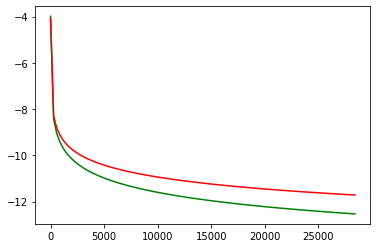

In [87]:
t2 = powerlaw.fit(data) # always [0.25556190626454967, -5.3087461247103575e-25, 41315.39602489741]

t = np.linspace(data.min() + 1, data.max(), 100)

t1 = theta_opt.x # eg [1.06399195e-01, -9.90930233e-01, 4.00000000e+04]

plt.plot(t, powerlaw.logpdf(t, t1[0], t1[1], t1[2]), color="g")
plt.plot(t, powerlaw.logpdf(t, t2[0], t2[1], t2[2]), color="r")

In [ ]:
plt.figure(figsize = (15, 5))
plt.suptitle("Power-law approximation")

plt.subplot(121)
plt.title("Received ratings")
mle_tuple = powerlaw.fit(df_concise["inRating_count"])
print("Received:\n\talpha = {:.2f}\n\tscale = {:.2f}".format(mle_tuple[0], mle_tuple[2]))
r = powerlaw.rvs(mle_tuple[0], scale = mle_tuple[2], size = 1000)
plt.hist(r, histtype = 'stepfilled', log = True, bins = 25)

plt.subplot(122)
plt.title("Given ratings")
mle_tuple = powerlaw.fit(df_concise["outRating_count"])
print("Given:\talpha = {:.2f}\n\tscale = {:.2f}".format(mle_tuple[0], mle_tuple[2]))
r = powerlaw.rvs(mle_tuple[0], scale = mle_tuple[2], size = 1000)
plt.hist(r, histtype = 'stepfilled', log = True, bins = 25)


plt.show()

In [ ]:
# Given ratings
def get_title(name, df):
    mu = np.round(df.mean(), 2)
    sd = np.round(df.std(), 2)
    return "{} - mu = {}, sd = {}".format(name, mu, sd)

data = [
    df["rating_weight"],
    df[df["user_gender"] == "F"]["rating_weight"],
    df[df["user_gender"] == "M"]["rating_weight"],
    df[df["user_gender"] == "U"]["rating_weight"]
]

titles = [
    "All",
    "Females",
    "Males",
    "Unknown"
]

plt.figure(figsize = (15, 10))
for i in range(len(data)):
    plt.subplot(2, 2, i + 1)
    plt.hist(data[i], bins = 10)
    plt.title(get_title(titles[i], data[i]))

plt.show()

## 3) Small Community

### Obratining small community

In [ ]:
## obtaining small community
df_small = df_detailed[(df_detailed["user_gender"] == "M") & (df_detailed["user_straight"] == False)]
df_small_edges = df[df["user_id"].isin(df_small["user_id"])]

print("nodes:", df_small.shape[0])
print("edges:", df_small_edges.shape[0])

#df_small[["user_id", "user_gender", "user_straight"]].to_csv("data/gender_small.csv", sep = ",", index = False)
#df_small_edges.to_csv("data/ratings_small.csv", sep = ",", index = False)

### Cumulative Degree Distribution

In [ ]:
plt.figure(figsize = (15, 5))
plt.suptitle("Cumulative Distribution of Degrees")

plt.subplot(121)
plt.title("In-degrees")
plt.hist(df_small["inRating_count"], cumulative = -1, bins = 25, log = True)

plt.subplot(122)
plt.title("Out-degrees")
plt.hist(df_small["outRating_count"], cumulative = -1, bins = 25, log = True)

plt.show()

### Average Clustering Coefficient

In [ ]:
H = nx.from_pandas_edgelist(df_small_edges, source = "user_id", target = "rating_profile", edge_attr = "user_gender", create_using=nx.DiGraph())
print("average clustering:", nx.average_clustering(H))

### Centralities

In [ ]:
# centralities
degc = nx.degree_centrality(H)
#betw = nx.betweenness_centrality(H)
clos = nx.closeness_centrality(H)
eig = nx.eigenvector_centrality_numpy(H)

centrality = pd.DataFrame({"degree": degc, "closeness": clos, "eigenvector": eig})
sns.pairplot(centrality)

### Connected Components

In [ ]:
print("Is weakly connected:", nx.is_weakly_connected(H))
components = list(nx.strongly_connected_components(H))

print("# of nodes:", len(H.nodes))
print("# of strongly connected components:", len(components))

## Reciprocal Graph with Positive Ratings (males)

In [ ]:
curr_g = G3
curr_df = df_rec_male
curr_df

In [ ]:
# removing isolated nodes
isolates = list(nx.isolates(curr_g))
print("# of isolated nodes:", len(isolates))
curr_g.remove_nodes_from(isolates)

In [ ]:
print("nodes:", len(curr_g.nodes))
print("edges:", len(curr_g.edges))

In [ ]:
# degree distribution
plt.figure(figsize = (15, 5))
degrees = [d for n, d in curr_g.degree()]
plt.hist(degrees, cumulative = -1, bins = 25, log = True)
plt.title("Degree distribution (log-scaled)")
plt.show()

In [ ]:
# connected components
conn_components = list(nx.connected_components(curr_g))
print("# of connected components:", len(conn_components))

comp_size = []
for c in conn_components:
    comp_size.append(len(c))
comp_size.sort(reverse = True)
print("sorted sizes of components:", comp_size[:10])

### GraphLab

In [ ]:
from graphlab import SFrame, SGraph
from graphlab import pagerank

In [ ]:
data = SFrame.read_csv("data/ratings_small.csv")
g = SGraph().add_edges(data, src_field = "user_id", dst_field = "rating_profile")

In [ ]:
# pagerank
pr = pagerank.create(g, threshold = 0.0001, max_iterations = 20)
pr.summary()
df_pagerank = pr.pagerank.to_dataframe

In [ ]:
display(df_pagerank)